# Lineare Regression mit zwei unabhängigen Variablen

- `matplotlib.pyplot`: Die grundlegende Bibliothek für die Erstellung von Plots, Achsen und Anpassungen.

- `seaborn`: Baut auf Matplotlib auf und wird für ansprechendere statistische Visualisierungen und das Plot-Design verwendet.

- `matplotlib.lines.Line2D`: Speziell für die Erstellung benutzerdefinierter Legendeneinträge, z.B. für 3D-Oberflächen.

## 0. Setup

In [421]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm

from matplotlib.lines import Line2D
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from pathlib import Path # Import für professionelles Pfad-Management

In [422]:
# Konfiguration

# Pfad
DATA_FOLDER = "Data"
FILE_NAME = "Eisverkauf_Beobachtungsdaten_Matrix.xlsx"
DATA_FILE = Path(DATA_FOLDER) / FILE_NAME

# Parameter
RANDOM_STATE = 42 # Für reproduzierbare Ergebnisse

# Matplotlib-Plots direkt im Notebook anzeigen und Theme setzen
%matplotlib inline
sns.set_theme(style="whitegrid")

## 1. Daten vorbereiten 

### 1.1 Daten einlesen und umformen

In [423]:
try:
    df = pd.read_excel(DATA_FILE)
    print(f"Daten erfolgreich geladen: \n{len(df)} Datensätze gefunden.")
except FileNotFoundError:
    print(f"FEHLER: Die Datei '{DATA_FILE}' wurde nicht gefunden. Bitte überprüfen Sie den Pfad.")
    df = None

Daten erfolgreich geladen: 
9 Datensätze gefunden.


### 1.2 Daten von Matrix- in Listenform umwandeln (Unpivot)

In [424]:
# Die ID-Variable ist die erste Spalte, 
id_vars = ['Temperatur\nRegen']

# Temperaturwerte aud er ersten Zeile auslesen 
value_vars = [] 
for col in df.columns:
    if isinstance(col, (int, float)):
        value_vars.append(col) # Wenn ja, füge ihn zur Liste hinzu
print(f"Temp Werte: {value_vars}")

# Daten umformen (zwei neue Spalten Erstellen)
# 'Temperatur' wird der neue Spaltenname für die ursprünglichen numerischen Spaltennamen (z.B. 14, 18)
# 'Eisabsatz' wird der neue Spaltenname für die Werte in diesen Spalten.
df_transformed = pd.melt(df, id_vars=id_vars, value_vars=value_vars, var_name='Temperatur', value_name='Eisabsatz')

Temp Werte: [14, 18, 22, 25, 26, 28, 30]


In [425]:
# Spalte für bessere Lesbarkeit umbenennen
df_transformed = df_transformed.rename(columns={'Temperatur\nRegen': 'Regen'})

# Datentypen anpassen
df_transformed['Temperatur'] = df_transformed['Temperatur'].astype(int)
df_transformed = df_transformed.dropna(subset=['Eisabsatz'])               # Entfernt  alle unvollständigen Datenpunkte 
df_transformed['Eisabsatz'] = df_transformed['Eisabsatz'].astype(float)

print(f"Transformierter DataFrame (erste 5 Zeilen): \n{df_transformed.head()}")

Transformierter DataFrame (erste 5 Zeilen): 
   Regen  Temperatur  Eisabsatz
0      0          14        1.0
2      2          14        0.5
4      5          14        0.0
8     10          14        0.0
9      0          18       16.0


## 2 Training unb Bewertung

## 2.1 Features (X) und Zielvariable (y) definieren

In [426]:
features = ['Temperatur', 'Regen']
X = df_transformed[features]
y = df_transformed['Eisabsatz']
print(f"Gesamter Datensatz wird für das Training verwendet: {len(df_transformed)} Datensätze.")

Gesamter Datensatz wird für das Training verwendet: 29 Datensätze.


### 2.2 Trainieren 

In [427]:
# Training
model = LinearRegression()
model.fit(X, y)

# Parameter 
a = model.intercept_
b = model.coef_[0]
c = model.coef_[1]

print("\nModellergebnisse:")
print(f"Achsenabschnitt (Intercept): {a:.2f}")
print(f"Koeffizient für 'Temperatur': {b:.2f}")
print(f"Koeffizient für 'Regen': {c:.2f}")
print(f"\nFormel: Eisabsatz = {a:.2f} + ({b:.2f} * Temperatur) + ({c:.2f} * Regen)")


Modellergebnisse:
Achsenabschnitt (Intercept): -15.24
Koeffizient für 'Temperatur': 1.66
Koeffizient für 'Regen': -1.78

Formel: Eisabsatz = -15.24 + (1.66 * Temperatur) + (-1.78 * Regen)


## 3. Bewertung

In [428]:

# Metriken zur Güteberechnung
y_pred = model.predict(X)
mae = mean_absolute_error(y, y_pred)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y, y_pred)

# Adjustiertes R-Quadrat berechnen
n = len(y)       # Anzahl der Beobachtungen
p = X.shape[1]   # Anzahl der Prädiktoren
r2_adj = 1 - (1 - r2) * ((n - 1) / (n - p - 1))

print("\nModellgüte (bewertet auf allen Daten):")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-Quadrat (R²): {r2:.4f}")
print(f"Adjustiertes R-Quadrat (R²_adj): {r2_adj:.4f}")


Modellgüte (bewertet auf allen Daten):
Mean Absolute Error (MAE): 3.26
Mean Squared Error (MSE): 17.81
Root Mean Squared Error (RMSE): 4.22
R-Quadrat (R²): 0.8759
Adjustiertes R-Quadrat (R²_adj): 0.8663


## 4 Visualisierung

In [429]:
# Erstellen eines Gitters für die Regressionsebene
x_surf, y_surf = np.meshgrid(
    np.linspace(df_transformed['Temperatur'].min(), df_transformed['Temperatur'].max(), 10),           # Wertebereich x
    np.linspace(df_transformed['Regen'].min(), df_transformed['Regen'].max(), 10)                      # Wertebereich y
)

z_surf = a + b * x_surf + c * y_surf                                # Punkte der Ebene

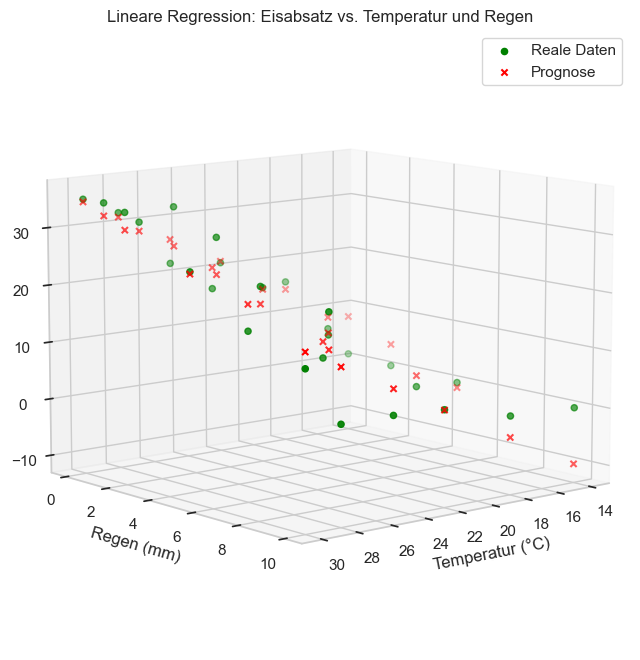

In [449]:
# 3D-Plot erstellen
fig = plt.figure(figsize=(8, 30))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X['Temperatur'], X['Regen'], y, c='green', marker='o', label='Reale Daten')              # Reale Datenpunkte
ax.scatter(X['Temperatur'], X['Regen'], y_pred, c='red', marker='x', label='Prognose')              # Prognose Daten 
#ax.scatter(x_surf, y_surf, z_surf, alpha=0.1, color='blue', label='Modell-Ebene')                   # Regressionsebene 

ax.set_xlabel('Temperatur (°C)')
ax.set_ylabel('Regen (mm)')
ax.set_zlabel('Eisabsatz (x1000 €)')
ax.set_title('Lineare Regression: Eisabsatz vs. Temperatur und Regen')
ax.view_init(elev=10, azim=50)
ax.legend()
plt.show()

## 5. 2D Darstellung ???

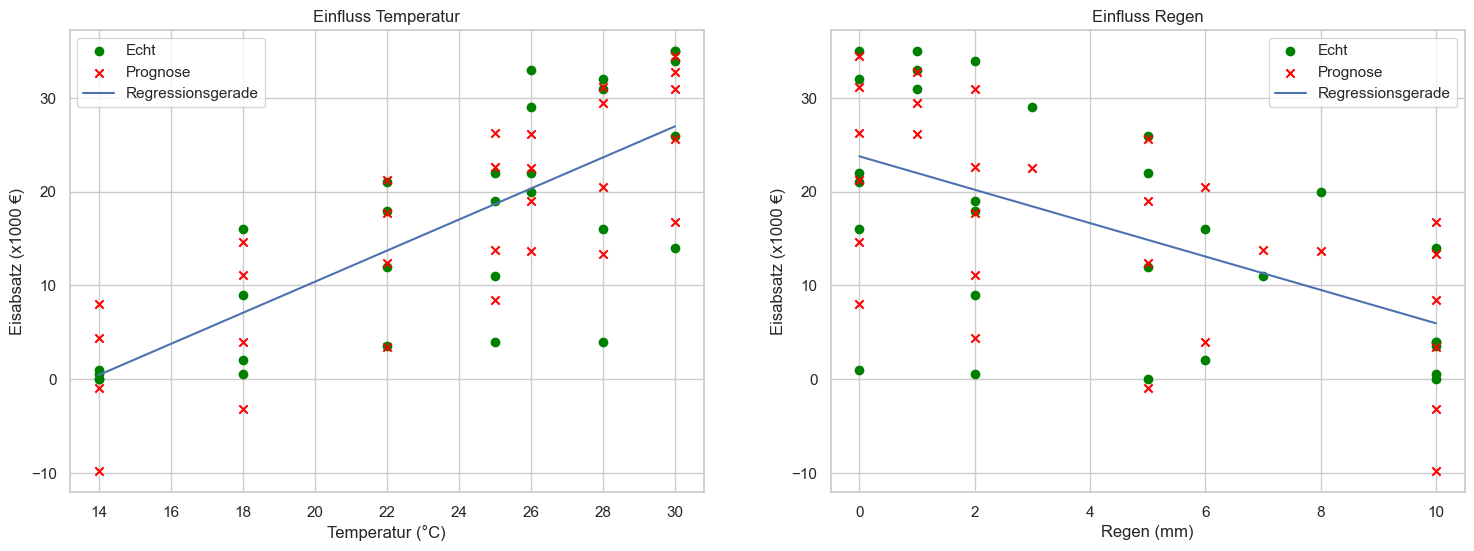

In [431]:
# Setup
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# --- Plot 1: Temperatur ---

ax1.scatter(X['Temperatur'], y, c='green', label='Echt')
ax1.scatter(X['Temperatur'], y_pred, c='red', marker='x', label='Prognose')

slope_temp = b  
intercept_temp = a + c * X['Regen'].mean()                              # Achsenabschnitt, angepasst um den mittleren Regeneinfluss
x_line1 = np.array([X['Temperatur'].min(), X['Temperatur'].max()])
y_line1 = slope_temp * x_line1 + intercept_temp
ax1.plot(x_line1, y_line1, 'b-', label='Regressionsgerade')

ax1.set_title('Einfluss Temperatur')
ax1.set_xlabel('Temperatur (°C)')
ax1.set_ylabel('Eisabsatz (x1000 €)')
ax1.legend()

# --- Plot 2: Regen ---

ax2.scatter(X['Regen'], y, c='green', label='Echt')
ax2.scatter(X['Regen'], y_pred, c='red', marker='x', label='Prognose')

slope_regen = c 
intercept_regen = a + b * X['Temperatur'].mean()                # Achsenabschnitt, angepasst um den mittleren Temperatureinfluss
x_line2 = np.array([X['Regen'].min(), X['Regen'].max()])
y_line2 = slope_regen * x_line2 + intercept_regen
ax2.plot(x_line2, y_line2, 'b-', label='Regressionsgerade')

ax2.set_title('Einfluss Regen')
ax2.set_xlabel('Regen (mm)')
ax2.set_ylabel('Eisabsatz (x1000 €)')
ax2.legend()

plt.show()

## 6. Neue Daten Erstellen

In [432]:
# Fiktiven Wetterdaten erstellen.
anzahl_neuer_werte = 200
neue_wetterdaten = {
    'Temperatur': np.random.uniform(5, 40, anzahl_neuer_werte),     # Temperaturen zwischen 5°C und 40°C
    'Regen': np.random.uniform(0, 30, anzahl_neuer_werte)           # Regen zwischen 0mm und 30mm
}
df_neue_werte = pd.DataFrame(neue_wetterdaten)
df_neue_werte = df_neue_werte.round(1)
print(f"{len(df_neue_werte)} neuen Wertepaaren wurde erstellt.")

# Speichern in einer Excel-Datei
datei_neue_werte = Path(DATA_FOLDER) / 'neue_wetterdaten.xlsx'
df_neue_werte.to_excel(datei_neue_werte, index=False)
print(f"Beispiel der zu prognostizierenden Daten: \n{df_neue_werte.head()}")

200 neuen Wertepaaren wurde erstellt.
Beispiel der zu prognostizierenden Daten: 
   Temperatur  Regen
0        28.6   14.3
1        35.2   10.7
2        34.2    6.8
3        26.2   23.2
4        19.2    5.7


In [433]:
# Vorhersage 
X_new = df_neue_werte[features]
y_pred_new = model.predict(X_new)
df_neue_werte['Vorhersage'] = y_pred_new

print(f"Vorhersage der neuen Werte: \n{df_neue_werte.head()}")

Vorhersage der neuen Werte: 
   Temperatur  Regen  Vorhersage
0        28.6   14.3    6.735233
1        35.2   10.7   24.101205
2        34.2    6.8   29.391034
3        26.2   23.2  -13.105361
4        19.2    5.7    6.461521


## 7. Ergebnisse Speichern aller Daten

In [434]:
# Gesamten Datensatz 
df_all = pd.concat([df_transformed, df_neue_werte], ignore_index=True, sort=False)
print(f"Datensatz für alle Werte: \n{df_all.head()}")

Datensatz für alle Werte: 
   Regen  Temperatur  Eisabsatz  Vorhersage
0    0.0        14.0        1.0         NaN
1    2.0        14.0        0.5         NaN
2    5.0        14.0        0.0         NaN
3   10.0        14.0        0.0         NaN
4    0.0        18.0       16.0         NaN


In [ ]:
# Vorhersage 
X_all = df_all[features]
y_pred_all = model.predict(X_all)

df_all['Vorhersage'] = y_pred_all
print(f"Vorhersage für alle Daten: \n{df_all.head()}")

# Speichern 
datei_alle_ergebnisse = Path(DATA_FOLDER) / 'alle_ergebnisse.xlsx'
df_all.to_excel(datei_alle_ergebnisse, index=False)


Vorhersage fpür alle Daten: 
   Regen  Temperatur  Eisabsatz  Vorhersage
0    0.0        14.0        1.0    7.989573
1    2.0        14.0        0.5    4.425917
2    5.0        14.0        0.0   -0.919568
3   10.0        14.0        0.0   -9.828709
4    0.0        18.0       16.0   14.626780


## 8. Geometrischen Form 

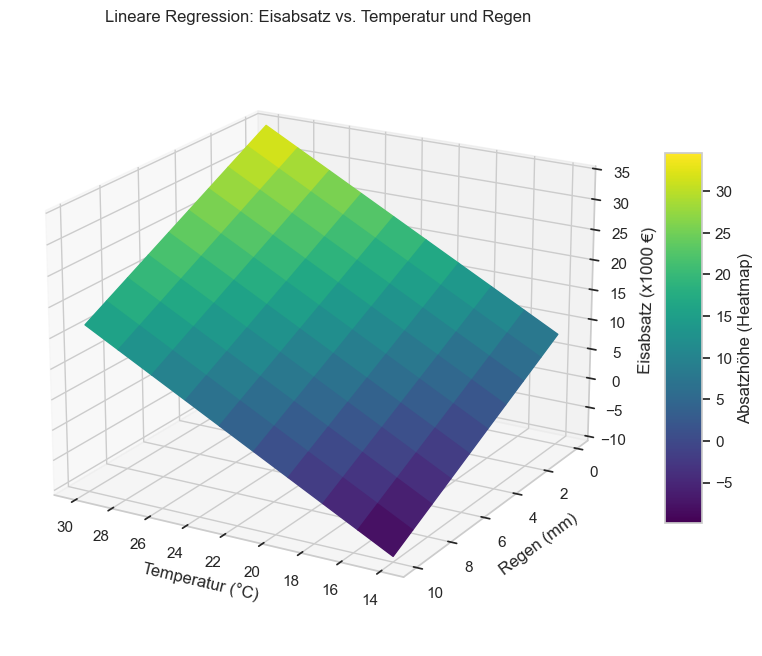

In [437]:
# 3D-Plot erstellen
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

norm = plt.Normalize(z_surf.min(), z_surf.max())
face_colors = cm.viridis(norm(z_surf))

surf = ax.plot_surface(x_surf, y_surf, z_surf, facecolors=face_colors, shade=False)

ax.set_xlabel('Temperatur (°C)')
ax.set_ylabel('Regen (mm)')
ax.set_zlabel('Eisabsatz (x1000 €)')
ax.set_title('Lineare Regression: Eisabsatz vs. Temperatur und Regen')
ax.view_init(elev=20, azim=120)

mappable = cm.ScalarMappable(cmap=cm.viridis, norm=norm)
fig.colorbar(mappable, ax=ax, shrink=0.6, aspect=10, label='Absatzhöhe (Heatmap)')

plt.show()